#### Libraries

In [1]:
from operator import itemgetter
from time import time
from typing import Any, Dict, TypedDict

from dotenv import load_dotenv
from IPython.display import Image
from langchain import hub
from langchain.agents import AgentExecutor, create_react_agent
from langchain.prompts import ChatPromptTemplate
from langchain_community.tools.google_scholar import GoogleScholarQueryRun
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.utilities.google_scholar import GoogleScholarAPIWrapper
from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnableLambda, RunnableParallel, RunnablePassthrough
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeColors
from langchain_groq import ChatGroq
from langchain_openai.chat_models import ChatOpenAI
from langgraph.graph import END, StateGraph
from nest_asyncio import apply as nest_asyncio_apply

In [2]:
_ = nest_asyncio_apply(), load_dotenv()

### 1. Tool use agent - Self-Hosted Llama3
_The model is hosted on 2 A100 GPUs with 80GB each one._

#### 1.1 Inference testing

In [3]:
# Generation options
generation_kwargs = {
    "temperature": 0.0,
    "max_tokens": 512,
}

In [4]:
# Use Llama3 with an OpenAI compatible server
llm = ChatOpenAI(
    model="meta-llama/Meta-Llama-3-70B-Instruct",
    openai_api_base="https://jjovalle99--llama3-serve-model.modal.run/v1",
    openai_api_key="EMPTY",
    model_kwargs={"stop": ["<|eot_id|>", "<|end_of_text|>"]},
    streaming=True,
    **generation_kwargs
)

In [5]:
input = "Who is your creator?"
start = time()
stream = llm.stream(input=input)
for token in stream:
    print(token.content, end="", flush=True)
end = time()
print(f"\nTime: {end - start:.2f}s")

I don't have a single "creator" in the classical sense. I was developed by a team of researcher at Meta AI and the Meta AI LLC. My development is the result of a collaboration between several experts in the field of natural language processing (NLP) and machine learning.

My knowledge was built from a massive corpus of text, including but not limited to:

* Web pages
* Books
* Articles
* Research papers
* Conversations

My model is based on a type of recurrent neural network called a transformer, which is particularly well-suited for processing sequential data like text. My training data includes a massive corpus of text, which I use to generate human-like responses to a wide range of questions and topics.

While I don't have a single "creator," I'm grateful to the many researcher, engineer, and developer who have contributed to my development and continue to improve me.
Time: 10.76s


In [8]:
input = "If 1=3, 2=3, 3=5, 4=4, 5=4; then, 6=?." \
"Think of your response step by step." \
"Return the final answer in the following JSON format `{'answer': <final_answer>}`."
start = time()
stream = llm.stream(input=input)
for token in stream:
    print(token.content, end="", flush=True)
end = time()
print(f"\nTime: {end - start:.2f}s")

A classic lateral thinking puzzle!

Let's break it down step by step:

1. `1=3`: The number of letters in the word "One" is 3 (O-N-E).
2. `2=3`: The number of letters in the word "Two" is 3 (T-W-O).
3. `3=5`: The number of letters in the word "Three" is 5 (T-H-R-E-E).
4. `4=4`: The number of letters in the word "Four" is 4 (F-O-U-R).
5. `5=4`: The number of letters in the word "Five" is 4 (F-I-V-E).

Now, let's apply the same pattern to `6`:

6. `6=?`: The number of letters in the word "Six" is... 3 (S-I-X).

So, the final answer is:

`{'answer': 3}`
Time: 11.34s


#### 1.1 Tools Setup
_We will be using [**Arxiv**](https://python.langchain.com/docs/integrations/tools/arxiv/), [**Google Scholar**](https://python.langchain.com/docs/integrations/tools/google_scholar/) and [**TavilySearch**](https://python.langchain.com/docs/integrations/tools/tavily_search/) tools. Note that **vLLM** [does not have support for tools yet](https://docs.vllm.ai/en/latest/serving/openai_compatible_server.html), so the implementation is not that straightforward_

In [154]:
# Definiton of the tools
google_scholar = GoogleScholarQueryRun(api_wrapper=GoogleScholarAPIWrapper(top_k_results=10))
arxiv = ArxivAPIWrapper(top_k_results=10)
tavily = TavilySearchResults(max_results=10)

In [10]:
# Testing arxiv tool
print(arxiv.run("Global Warming")[:250] + "...")

Published: 2010-12-15
Title: A possible relationship between Global Warming and Lightning Activity in India during the period 1998-2009
Authors: Felix Pereira B., Priyadarsini G., T. E. Girish
Summary: Lightning activity on a global scale has been st...


In [11]:
# Testing google scholar tool
print(google_scholar.run("Global Warming")[:250] + "...")

Title: Hurricanes and global warming
Authors: RA Pielke Jr
Summary: RA Pielke Jr, C Landsea, M Mayfield… - Bulletin of the …, 2005 - journals.ametsoc.org
Total-Citations: 467

Title: Global warming of 1.5° C
Authors: 
Summary: PC Change - World Meteo...


In [12]:
# Testing tavily tool (search engine)
print(tavily.invoke("Global Warming")[0])

{'url': 'https://www.nationalgeographic.org/encyclopedia/global-warming/', 'content': 'ENCYCLOPEDIC ENTRY\nENCYCLOPEDIC ENTRY\nGlobal Warming\nGlobal Warming\nEarth is warming up, and humans are at least partially to blame. The excess heat in the atmosphere has caused the average global temperature to rise overtime, otherwise known as global warming.\n The causes, effects, and complexities of global warming are important to understand so that we can fight for the health of our planet.\n The greenhouse effect is when the sun’s rays penetrate the atmosphere, but when that heat is reflected off the surface cannot escape back into space. When you reach out to them, you will need the page title, URL, and the date you accessed the resource.\n'}


#### 1.2 Agent runnable setup

In [13]:
# System prompt
system_prompt = """You are an AI research assistant with expertise in conducting literature reviews. Your role is to help the user thoroughly survey the scholarly literature on a particular research topic or question.

Remember, your goal is to save the user significant time and effort by finding, filtering, and making sense of large bodies of academic literature. Provide them with a comprehensive, well-organized, referenced, and insightful overview that they can build upon for their own research or use to get quickly up to speed on the topic.
"""

# User prompt
user_prompt = """Write a literature review on the topic of '{topic}' using only the following research information:

<|begin_of_research_information|>
{research}
<|end_of_research_information|>
"""

# LC Chatprompt template
prompt = ChatPromptTemplate.from_messages(
    messages=[
        ("system", system_prompt),
        ("user", user_prompt)
    ]
)

In [14]:
# Helper function to organize research
def organize_research(findings: Dict[str, Any]) -> str:
    return (
        findings["academic2"] + "\n\n"
        + "\n\n".join([str(result) for result in findings["tavily"]])
        + findings["academic1"] + "\n\n"
    )

In [15]:
# Agent definition
agent = (
    RunnableParallel(academic1=google_scholar, academic2=RunnableLambda(func=lambda x: arxiv.run(x), name="Arxiv"), tavily=tavily, topic=RunnablePassthrough())
    | {"research": RunnableLambda(func=organize_research, name="organize_research"), "topic": itemgetter("topic")}
    | prompt
    | llm
    | StrOutputParser()
)

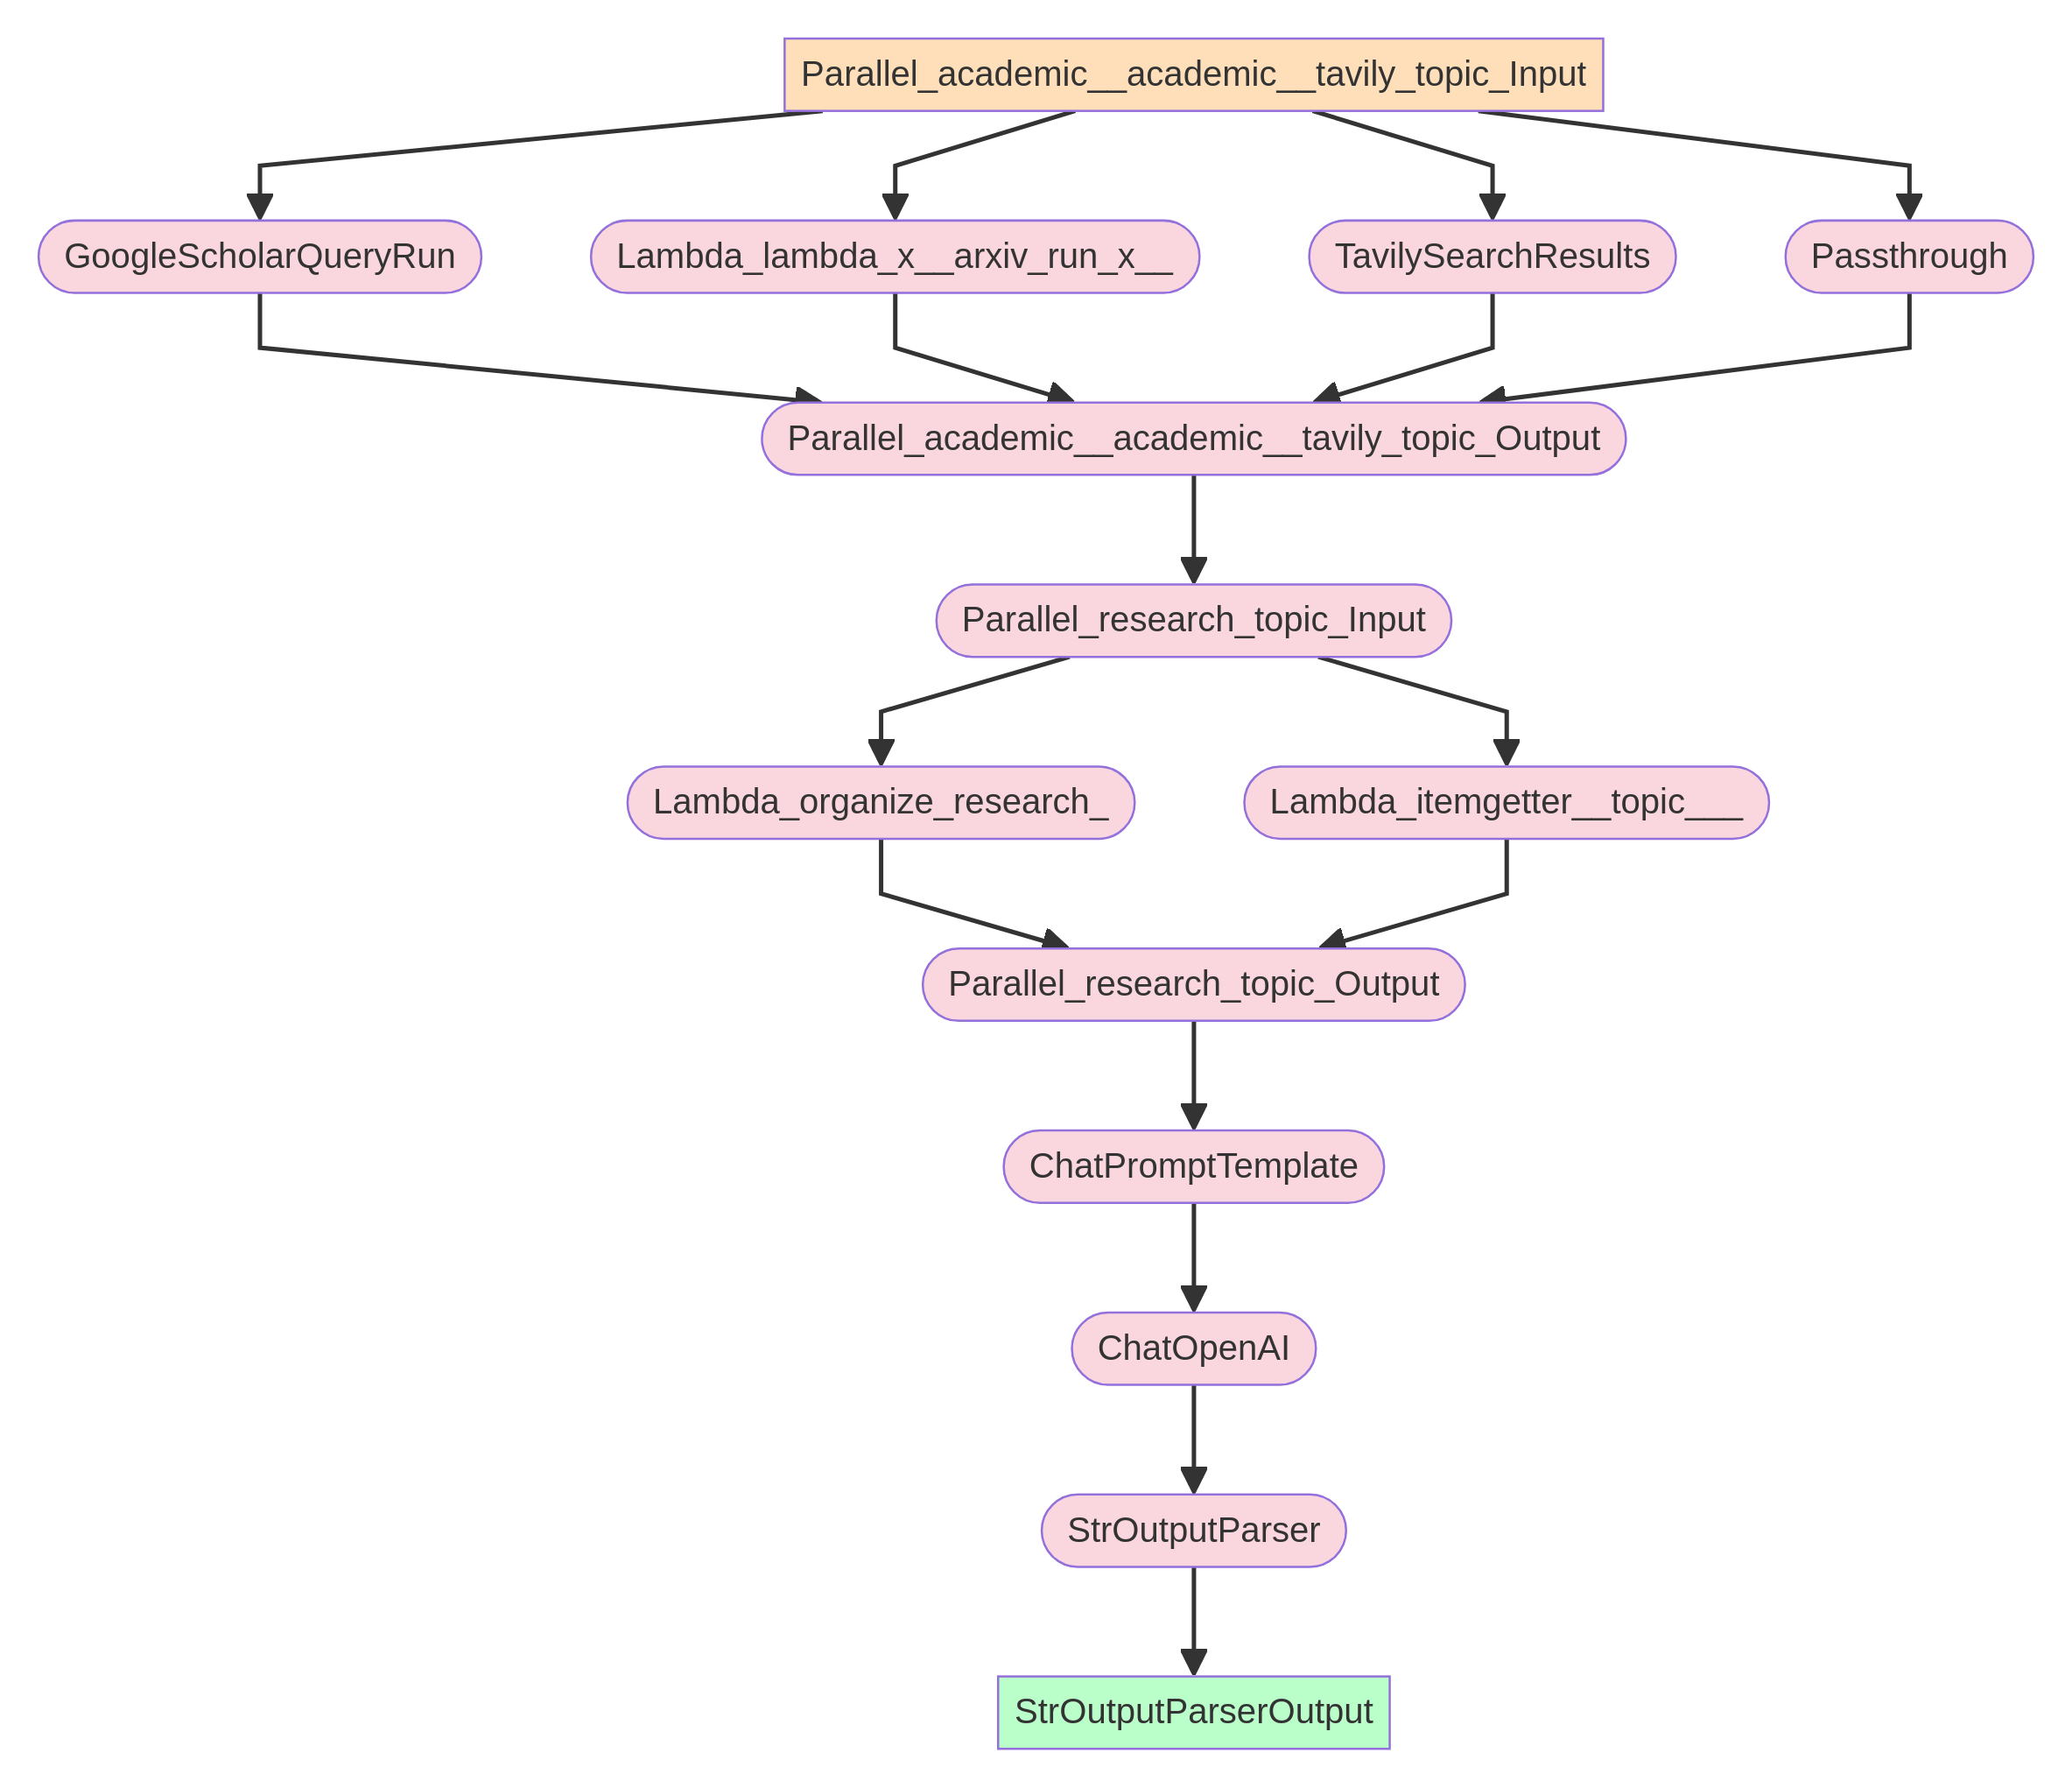

In [16]:
# Visualization
Image(agent.get_graph().draw_mermaid_png(
    curve_style=CurveStyle.LINEAR,
    node_colors=NodeColors(start="#ffdfba", end="#baffc9", other="#fad7de"),
    wrap_label_n_words=5,
    output_file_path=None,
    draw_method=MermaidDrawMethod.PYPPETEER,
    background_color="white",
    padding=5
), width=600, height=400)

#### 1.3 Agent runnable execution
_Checkout the runs in **LangSmith:**_
1. Artificial Intelligence for Soccer: https://smith.langchain.com/public/4e9dea4a-b9e8-411e-97d5-01fd345e8b04/r
2. Global Warming: https://smith.langchain.com/public/e5616779-c0b6-4656-a9f2-e22eaf0f2629/r

In [18]:
topic = "Artificial Intelligence for Soccer"
start = time()
stream = agent.stream(input=topic)
for token in stream:
    print(token, end="", flush=True)
end = time()
print(f"\nTime: {end - start:.2f}s")

Literature Review: Artificial Intelligence for Soccer

Introduction:
Artificial intelligence (AI) has been increasingly applied to various aspects of soccer, including player evaluation, team strategy, and game simulation. This literature review aims to provide a comprehensive overview of the current state of AI research in soccer, highlighting the key applications, techniques, and challenges in this field.

Player Evaluation and Ranking:
One of the primary applications of AI in soccer is player evaluation and ranking. PlayeRank, a data-driven framework, uses machine learning algorithms to evaluate player performance based on various metrics, such as passes, shots, and tackles (Pappalardo et al., 2019). This approach has been shown to outperform traditional methods and provides a more comprehensive understanding of player performance. Similarly, other studies have used AI to evaluate player skills, such as passing behavior, and to identify promising athletes (Zare et al., 2024; Liu et 

In [17]:
topic = "Global Warming"
start = time()
stream = agent.stream(input=topic)
for token in stream:
    print(token, end="", flush=True)
end = time()
print(f"\nTime: {end - start:.2f}s")

**Global Warming: A Comprehensive Review of Causes, Effects, and Projections**

Global warming, also known as climate change, is a pressing issue that has garnered significant attention in recent years. The scientific consensus is clear: human activities, particularly the burning of fossil fuels and deforestation, are releasing large amounts of greenhouse gases, such as carbon dioxide and methane, into the atmosphere, leading to a global average temperature increase of over 1°C since the late 19th century (IPCC, 2021). This review aims to provide a comprehensive overview of the causes, effects, and projections of global warming, synthesizing the latest research and findings from various fields.

**Causes of Global Warming**

The primary cause of global warming is the increasing levels of greenhouse gases in the atmosphere, primarily carbon dioxide (CO2), which trap heat and prevent it from being released back into space. The main sources of CO2 emissions are:

1. **Fossil fuel combusti

#### 1.4 GPU usage
![img](assets/modal1.png)

### 2. Tool use agent - Groq-Llama3

#### 2.1 Inference testing

In [129]:
# Define Groq-Llama3
groq_llm = ChatGroq(
    model_name="llama3-70b-8192",
    temperature=0.0,
    max_tokens=512,
    streaming=False
)

In [130]:
# Test inference 1
input = "Who is your creator?"
start = time()
stream = groq_llm.stream(input=input)
for token in stream:
    print(token.content, end="", flush=True)
end = time()
print(f"\nTime: {end - start:.2f}s")

I don't have a single "creator" in the classical sense. I was developed by a team of researcher at Meta AI and the Meta AI LLC. Meta AI is an artificial intelligence research laboratory that focuses on developing and applying various forms of AI to help humans learn, communicate, and solve complex problems.

My knowledge was built from a massive corpus of text, including but not limited to books, articles, and websites. This corpus is sourced from various places, including but not limited to books, articles, and websites. My model is trained using a range of technologies such as masked language modeling and next sentence prediction.

My responses are generated based on patterns and relationships in the data I was trained on, rather than on any personal opinions or biases. I don't have personal feelings, emotions, or motivations, and I don't have a personal identity or consciousness.

That being said, I'm designed to be helpful and assist with a wide range of tasks and questions to the 

In [131]:
# Test inference 2
input = "If 1=3, 2=3, 3=5, 4=4, 5=4; then, 6=?." \
"Think of your response step by step." \
"Return the final answer in the following JSON format `{'answer': <final_answer>}`."
start = time()
stream = groq_llm.stream(input=input)
for token in stream:
    print(token.content, end="", flush=True)
end = time()
print(f"\nTime: {end - start:.2f}s")

A classic lateral thinking puzzle!

Let's break it down step by step:

1. 1=3: The number of letters in the written form of "one" is 3 (O-N-E).
2. 2=3: The number of letters in the written form of "two" is 3 (T-W-O).
3. 3=5: The number of letters in the written form of "three" is 5 (T-H-R-E-E).
4. 4=4: The number of letters in the written form of "four" is 4 (F-O-U-R).
5. 5=4: The number of letters in the written form of "five" is 4 (F-I-V-E).

Now, let's apply the same pattern to 6:

6=? : The number of letters in the written form of "six" is 3 (S-I-X).

So, the answer is:

`{'answer': 3}`
Time: 0.95s


**Notice how the improvement in inference time with Groq!!!**

#### 2.2 Tools Setup
_Groq support tool calling !!_

In [159]:
prompt = hub.pull("hwchase17/react")
print(prompt.template)

Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}


In [164]:
tools = [tavily]
react_agent = create_react_agent(groq_llm, tools, prompt)
agent_executor = AgentExecutor(
    agent=react_agent, 
    tools=tools,
    verbose=True,
    handle_parsing_errors=True,
    max_iterations = 5
)

In [167]:
input = "What is the best way to improve at coding"
start = time()
agent_executor.invoke({"input": input})
end = time()
print(f"\nTime: {end - start:.2f}s")



> Entering new AgentExecutor chain...
Thought: I need to find a reliable source that provides guidance on improving coding skills.

Action: tavily_search_results_json
Action Input: "best ways to improve coding skills"
[{'url': 'https://medium.com/codex/become-a-pro-programmer-10-tips-and-strategies-for-improving-your-coding-skills-75863d589533', 'content': 'Coding challenges and hackathons are great ways to test your skills and learn from others. These events can provide a fun and challenging environment in which you can practice your coding skills ...'}, {'url': 'https://www.hellobonsai.com/blog/how-to-improve-coding-skills', 'content': '9. Do something new each day. Absolutely no-one becomes a coding guru overnight. It takes hard work, practice, and determination. However, if you want to add a little jet fuel to your development, you should take some time out each day and challenge yourself with something new.'}, {'url': 'https://www.fullstackacademy.com/blog/how-to-improve-coding-